<a href="https://colab.research.google.com/github/saritmaitra/Momentum_Trading/blob/main/Weekly_Series_Momentum_Signal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.transforms as transform
import matplotlib.gridspec as gridspec
import pandas as pd
from pandas.tseries.offsets import MonthEnd
pd.options.mode.chained_assignment = None
pd.set_option('use_inf_as_na', True)

In [2]:
from datetime import datetime
tickers=["SGRY", "NTRA", "Z", "FATE", "DIS", "GM", 'BPMC', "PTC"]
ls_key = 'Adj Close'
start = datetime(2018,1,1)
 
df = yf.download(tickers,start, freq='w')
prices = df[[("Adj Close", s) for s in tickers]]
prices.columns = prices.columns.droplevel(level=0)
prices

[*********************100%***********************]  8 of 8 completed


,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-02,13.350000,9.470000,42.480000,6.300000,108.726067,38.072212,80.010002,61.160000
2018-01-03,12.900000,9.510000,42.970001,6.500000,109.192856,39.001244,84.010002,61.939999
2018-01-04,12.900000,9.720000,42.130001,6.990000,109.144241,40.203526,78.550003,63.000000
2018-01-05,12.650000,9.900000,42.610001,6.820000,108.551003,40.085114,77.739998,63.650002
2018-01-08,13.150000,9.790000,42.759998,6.590000,106.994995,40.276390,74.639999,64.400002
...,...,...,...,...,...,...,...,...
2021-07-29,55.270000,112.160004,107.970001,86.040001,178.350006,57.279999,84.739998,133.029999
2021-07-30,54.560001,114.519997,106.260002,82.800003,176.020004,56.840000,87.870003,135.449997
2021-08-02,54.540001,112.330002,107.519997,85.080002,175.550003,57.029999,86.980003,131.070007


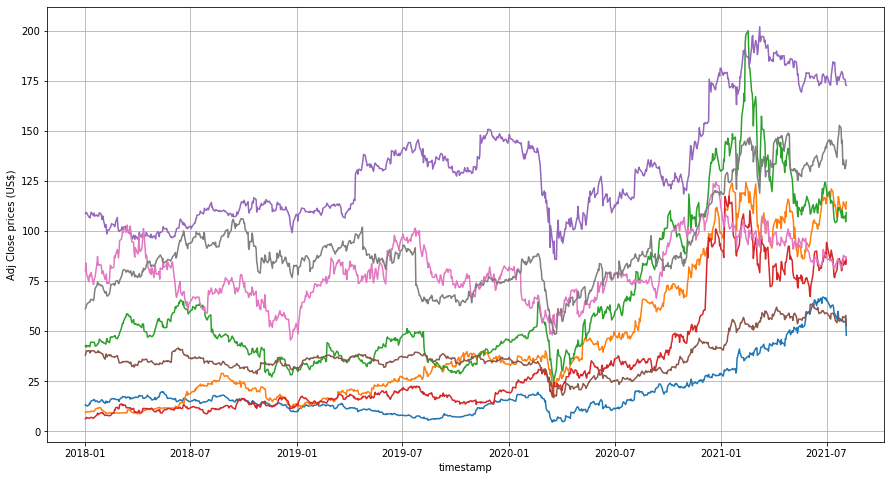

In [3]:
plt.figure(figsize= (15,8))
plt.plot(prices, label = 'Daily Closing price' )
# plt.xticks([])
plt.ylabel('Adj Close prices (US$)'); plt.xlabel('timestamp')
plt.grid(True); plt.show()

In [4]:
# monthly_ret = prices.pct_change().resample('m').agg(lambda x: (x+1).prod() - 1)
# monthly_ret

In [5]:
# returns = prices.copy()
weekly_returns = df['Adj Close'].resample('w').mean().pct_change()
# prices.pct_change().resample('w').agg(lambda x: (x+1).prod() - 1)


# returns.apply(lambda x: x.shift(-1)/x - 1, axis = 0)
weekly_returns # sanity check

,BPMC,DIS,FATE,GM,NTRA,PTC,SGRY,Z
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,-0.032188,-0.012542,0.011950,0.016519,0.026943,0.041746,0.093436,0.017639
2018-01-21,-0.023806,0.003070,0.042038,-0.002243,0.046670,0.050827,0.098164,0.013269
2018-01-28,0.111969,0.000293,0.231646,-0.007111,0.123548,0.075143,-0.049518,0.005687
2018-02-04,-0.044719,-0.009446,0.064120,-0.027221,-0.085979,-0.016439,0.038566,0.012103
...,...,...,...,...,...,...,...,...
2021-07-11,-0.022242,-0.011585,-0.028662,-0.029258,0.019570,0.016977,-0.053626,-0.042257
2021-07-18,-0.038163,0.051092,-0.089868,0.007070,-0.026625,-0.016805,-0.034351,-0.074559
2021-07-25,0.035746,-0.040496,0.057189,-0.035230,-0.023180,0.024155,-0.047342,0.013571


In [6]:
# ranking of the returns
returns_rank = weekly_returns.rank(axis=1,method='average', numeric_only=True, 
                            na_option='keep', ascending=False, pct=False)
returns_rank

,BPMC,DIS,FATE,GM,NTRA,PTC,SGRY,Z
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,8.0,7.0,6.0,5.0,3.0,2.0,1.0,4.0
2018-01-21,8.0,6.0,4.0,7.0,3.0,2.0,1.0,5.0
2018-01-28,3.0,6.0,1.0,7.0,2.0,4.0,8.0,5.0
2018-02-04,7.0,4.0,1.0,6.0,8.0,5.0,2.0,3.0
...,...,...,...,...,...,...,...,...
2021-07-11,4.0,3.0,5.0,6.0,1.0,2.0,8.0,7.0
2021-07-18,6.0,1.0,8.0,2.0,4.0,3.0,5.0,7.0
2021-07-25,2.0,7.0,1.0,6.0,5.0,3.0,8.0,4.0


For each period(i), we want to calculate the average return for period(i) of the 2 stocks from the list that had the best performance over the previous period (period(i-1)).

In [7]:
# Creating a mask to select only 2 best returns per period, shifting down one line, replacing NaN in first line by false
import numpy as np
mask = (returns_rank < 6).shift(1) 
mask = mask.replace(np.nan,False)
mask

,BPMC,DIS,FATE,GM,NTRA,PTC,SGRY,Z
Date,,,,,,,,
2018-01-07,False,False,False,False,False,False,False,False
2018-01-14,False,False,False,False,False,False,False,False
2018-01-21,False,False,False,True,True,True,True,True
2018-01-28,False,False,True,False,True,True,True,True
2018-02-04,True,False,True,False,True,True,False,True
...,...,...,...,...,...,...,...,...
2021-07-11,True,False,True,False,True,True,False,True
2021-07-18,True,True,True,False,True,True,False,False
2021-07-25,False,True,False,True,True,True,True,False


In [8]:
# Applying the mask to the returns
best_returns = weekly_returns[mask]
best_returns

,BPMC,DIS,FATE,GM,NTRA,PTC,SGRY,Z
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,NaN,NaN,NaN,-0.002243,0.046670,0.050827,0.098164,0.013269
2018-01-28,NaN,NaN,0.231646,NaN,0.123548,0.075143,-0.049518,0.005687
2018-02-04,-0.044719,NaN,0.064120,NaN,-0.085979,-0.016439,NaN,0.012103
...,...,...,...,...,...,...,...,...
2021-07-11,-0.022242,NaN,-0.028662,NaN,0.019570,0.016977,NaN,-0.042257
2021-07-18,-0.038163,0.051092,-0.089868,NaN,-0.026625,-0.016805,NaN,NaN
2021-07-25,NaN,-0.040496,NaN,-0.035230,-0.023180,0.024155,-0.047342,NaN


In [9]:
# averaging the returns :
average_return = best_returns.mean(axis=1, skipna='true')
average_return 

Date
2018-01-07         NaN
2018-01-14         NaN
2018-01-21    0.041337
2018-01-28    0.077301
2018-02-04   -0.014183
                ...   
2021-07-11   -0.011323
2021-07-18   -0.024074
2021-07-25   -0.024418
2021-08-01   -0.015261
2021-08-08   -0.002298
Freq: W-SUN, Length: 188, dtype: float64

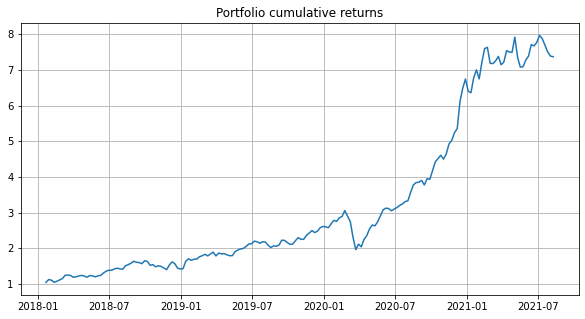

In [10]:
cum_returns = np.exp(np.log1p(average_return).cumsum())

plt.figure(figsize= (10,5))
plt.plot(cum_returns)
plt.title('Portfolio cumulative returns')
plt.grid(True); plt.show()

## Momentun signal computation:

In [26]:
momentum_signal = prices.resample('w').mean()

"""
return of the securities of last 6 weeks prior to the week we will be trading
we are not using current weeks because:
1. traditional momentum has atendency of short term reversal and longer term trend
2. it algns with execution strategy interms of  consistent with actual execution because
if we receive a signal on close price, we won't be able to execute immedeate
"""
momentum_signal = (momentum_signal.apply(func = lambda x: x.shift(1)/x.shift(7) - 1, axis = 0))
momentum_signal # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-11,0.256624,0.308538,0.106980,0.187551,0.032658,0.053702,-0.070858,0.102439
2021-07-18,0.116011,0.303590,0.017786,0.161628,-0.016055,-0.015257,-0.092064,0.084353
2021-07-25,0.011918,0.218272,-0.024912,0.136242,0.031960,-0.063552,-0.051574,0.082343


creating signal >= 7 means 1, <=2 means -1, else 0

In [27]:
# ranking of the returns
rank_df = momentum_signal.rank(axis=1,method='average', numeric_only=True, 
                            na_option='keep', ascending=False, pct=False)
rank_df

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-11,2.0,1.0,4.0,3.0,7.0,6.0,8.0,5.0
2021-07-18,3.0,1.0,5.0,2.0,7.0,6.0,8.0,4.0
2021-07-25,5.0,1.0,6.0,2.0,4.0,8.0,7.0,3.0


In [28]:
for col in rank_df.columns:
    rank_df[col] = np.where(rank_df[col] >= 7.0, 1, np.where(rank_df[col] <= 2.0, -1, 0))

rank_df.tail() # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2021-07-11,-1,-1,0,0,1,0,1,0
2021-07-18,0,-1,0,-1,1,0,1,0
2021-07-25,0,-1,0,-1,0,1,1,0
2021-08-01,1,-1,0,0,0,1,0,-1
2021-08-08,1,-1,0,0,0,1,0,-1


In [29]:
rank_df = momentum_signal.rank(axis =1)
rank_df # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2018-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-07-11,7.0,8.0,5.0,6.0,2.0,3.0,1.0,4.0
2021-07-18,6.0,8.0,4.0,7.0,2.0,3.0,1.0,5.0
2021-07-25,4.0,8.0,3.0,7.0,5.0,1.0,2.0,6.0


In [30]:
# returns = prices.pct_change()
portfolio = np.multiply(rank_df, weekly_returns)
portfolio.tail(50) # sanity check

,SGRY,NTRA,Z,FATE,DIS,GM,BPMC,PTC
Date,,,,,,,,
2020-08-30,-0.040026,0.221580,-0.210965,0.037280,-0.017060,0.040611,-0.019096,0.079007
2020-09-06,0.121487,0.043464,-0.146459,0.008982,-0.032911,0.215333,0.065650,0.094220
2020-09-13,-0.716251,-0.003968,-0.414145,0.084612,-0.163577,-0.409387,0.052091,-0.131007
2020-09-20,0.774642,-0.128635,1.108535,0.022663,-0.028393,0.089109,0.120077,0.375091
2020-09-27,0.950699,-0.237516,-0.156104,-0.280560,0.166470,-0.269242,-0.289036,0.052937
2020-10-04,0.200762,-0.011922,0.614283,0.058547,0.111686,-0.005592,0.492902,0.120661
2020-10-11,0.415803,-0.038949,0.882711,0.294058,0.005800,0.020929,0.608894,0.019293
2020-10-18,0.147745,0.126186,0.476460,0.197522,0.004504,0.136138,0.040397,-0.097601
2020-10-25,0.130479,-0.018718,-0.108700,0.849002,-0.043289,0.003921,-0.389849,-0.030910


In [31]:
portfolio_returns = portfolio.sum(axis=1) / 3
portfolio_returns

Date
2018-01-07    0.000000
2018-01-14    0.000000
2018-01-21    0.000000
2018-01-28    0.000000
2018-02-04    0.000000
                ...   
2021-07-11   -0.233272
2021-07-18   -0.213679
2021-07-25   -0.120341
2021-08-01   -0.074515
2021-08-08   -0.156433
Freq: W-SUN, Length: 188, dtype: float64

In [22]:
cum_returns

Date
2018-01-02    1.000000
2018-01-03    1.000000
2018-01-04    1.000000
2018-01-05    1.000000
2018-01-08    1.000000
                ...   
2021-07-29    0.009709
2021-07-30    0.009883
2021-08-02    0.008826
2021-08-03    0.009282
2021-08-04    0.005489
Length: 904, dtype: float64

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


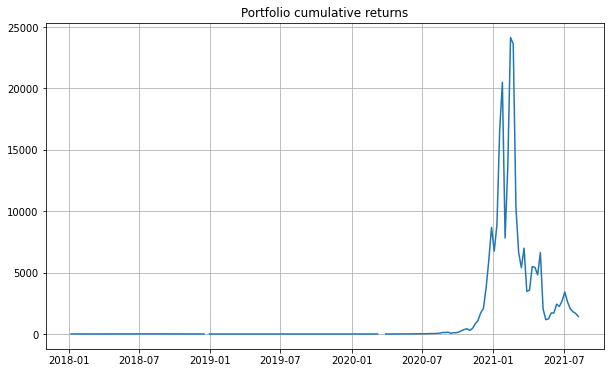

In [32]:
cum_returns = np.exp(np.log1p(portfolio_returns).cumsum())
plt.figure(figsize= (10,6))
plt.plot(cum_returns)
plt.title('Portfolio cumulative returns')
plt.grid(True); plt.show()

In [ ]:
# for col in rank_df.columns:
#     rank_df[col] = np.where(rank_df[col] >= 7.0, 1, np.where(rank_df[col] <= 2.0, -1, 0))

# rank_df.tail() # sanity check

In [ ]:
# portfolio = np.multiply(rank_df, returns)
# portfolio.tail(50) # sanity check

In [ ]:
# portfolio_returns = portfolio.sum(axis=1) / 3
# portfolio_returns

In [ ]:
# cum_returns = np.exp(np.log1p(portfolio_returns).cumsum())

# plt.figure(figsize= (15,8))
# plt.plot(cum_returns)
# plt.title('Portfolio cumulative returns')
# plt.grid(True); plt.show()